# Visualize Ansatz Structure

This notebook provides visualizations and analysis of the variational ansatz circuits used in the quantum Bayesian learner.

## Overview

We visualize:
1. Circuit structure and gate decomposition
2. Mask structure and active entanglers
3. Parameter sensitivity and gradients
4. Transpilation effects
5. Heisenberg entangler block structure


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer

# Import project modules
import sys
sys.path.insert(0, '..')
from src.ansatz import (
    build_ansatz, count_parameters, init_random_theta, init_full_mask,
    init_sparse_mask, get_default_pairs, heisenberg_entangler_block
)
from src.learner import forward_loss, set_seed
from src.transpile_utils import transpile_and_count_2q
from src.data import get_toy_dataset
from src.plots import plot_mask_heatmap

plt.style.use('default')
np.set_printoptions(precision=4, suppress=True)


## 1. Build and Draw Circuit

Construct a depth-3 ansatz with Heisenberg entanglers and visualize the circuit structure.


In [4]:
# Set parameters
n_qubits = 2
depth = 3
pairs = get_default_pairs(n_qubits)

# Initialize parameters
set_seed(42)
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

print("=" * 60)
print("Ansatz Construction")
print("=" * 60)
print(f"n_qubits: {n_qubits}")
print(f"depth: {depth}")
print(f"pairs: {pairs}")
print(f"theta shape: {theta.shape}")
print(f"mask shape: {mask.shape}")

# Build ansatz
ansatz = build_ansatz(
    n_qubits=n_qubits,
    depth=depth,
    theta=theta,
    mask=mask,
    pairs=pairs
)

print(f"\nCircuit properties:")
print(f"  Depth: {ansatz.depth()}")
print(f"  Number of gates: {len(ansatz.data)}")
print(f"  Number of qubits: {ansatz.num_qubits}")

# Count parameters
n_params = count_parameters(theta, mask)
print(f"  Total parameters: {n_params}")

# Draw circuit (using text output to avoid pylatexenc dependency)
print("\nCircuit visualization:")
try:
    # Try matplotlib first (requires pylatexenc)
    display(ansatz.draw(output='mpl', style='clifford'))
except Exception as e:
    # Fall back to text output if matplotlib fails
    print("Note: Using text output (install 'pylatexenc' for matplotlib visualization)")
    print(ansatz.draw(output='text', style='clifford'))


Ansatz Construction
n_qubits: 2
depth: 3
pairs: [(0, 1)]
theta shape: (3, 2, 5)
mask shape: (3, 1)

Circuit properties:
  Depth: 15
  Number of gates: 21
  Number of qubits: 2
  Total parameters: 21

Circuit visualization:
Note: Using text output (install 'pylatexenc' for matplotlib visualization)
     ┌──────────────┐ ┌────────────┐ ┌────────────────┐┌────────────────┐»
q_0: ┤ Rx(0.030472) ├─┤ Rz(-0.104) ├─┤0               ├┤0               ├»
     ├──────────────┤┌┴────────────┴┐│  Rxx(0.075045) ││  Ryy(0.094056) │»
q_1: ┤ Rx(-0.13022) ├┤ Rz(0.012784) ├┤1               ├┤1               ├»
     └──────────────┘└──────────────┘└────────────────┘└────────────────┘»
«                    ┌─────────────┐ ┌──────────────┐┌─────────────────┐»
«q_0: ─■─────────────┤ Rx(0.08794) ├─┤ Rz(0.077779) ├┤0                ├»
«      │ZZ(-0.1951) ┌┴─────────────┴┐├──────────────┤│  Rxx(0.0066031) │»
«q_1: ─■────────────┤ Rx(-0.085929) ├┤ Rz(0.036875) ├┤1                ├»
«                   └─────────

## 2. Visualize Mask Structure

Generate a random mask and visualize which entanglers are active using a heatmap.


Mask Visualization
Mask shape: (4, 2)
Active entanglers: 4 / 8
Sparsity: 50.00%


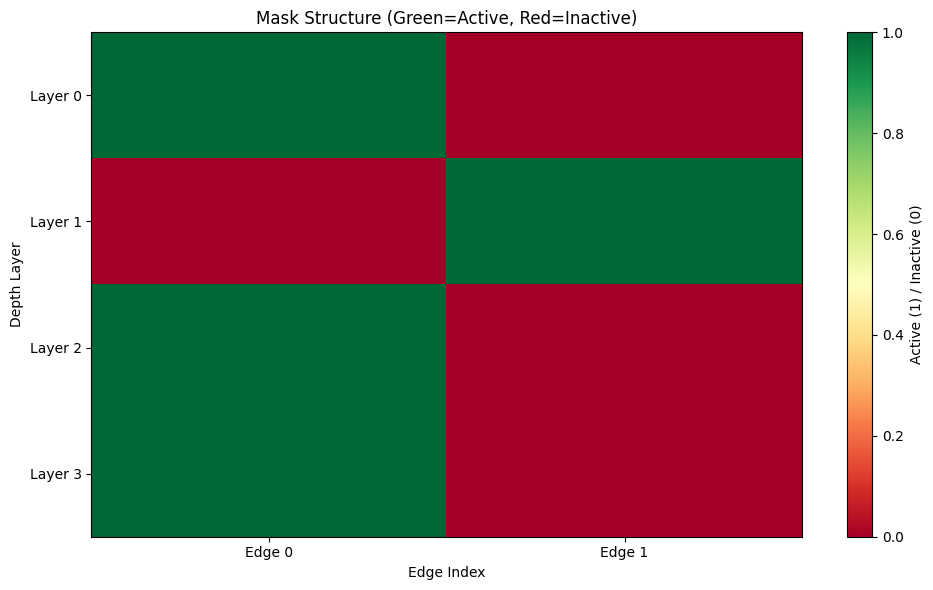

In [5]:
# Create a sparse mask
n_qubits = 3
depth = 4
pairs = get_default_pairs(n_qubits)
n_edges = len(pairs)

set_seed(42)
mask = init_sparse_mask(depth, n_edges, sparsity=0.5, seed=42)

print("=" * 60)
print("Mask Visualization")
print("=" * 60)
print(f"Mask shape: {mask.shape}")
print(f"Active entanglers: {np.sum(mask == 1)} / {mask.size}")
print(f"Sparsity: {1.0 - np.sum(mask == 1) / mask.size:.2%}")

# Visualize mask
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
im = ax.imshow(mask, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
ax.set_xlabel('Edge Index')
ax.set_ylabel('Depth Layer')
ax.set_title('Mask Structure (Green=Active, Red=Inactive)')
ax.set_yticks(range(depth))
ax.set_xticks(range(n_edges))
ax.set_yticklabels([f'Layer {d}' for d in range(depth)])
ax.set_xticklabels([f'Edge {i}' for i in range(n_edges)])
plt.colorbar(im, ax=ax, label='Active (1) / Inactive (0)')
plt.tight_layout()
plt.show()

# Also use plots.py function
plot_mask_heatmap(
    mask,
    title="Mask Heatmap (using plots.py)",
    fname="mask_visualization",
    output_dir="../results",
    verbose=False
)


## 3. Parameter Sensitivity

For individual parameters, compute numerical gradients by perturbing theta[d,q,k] and measuring the effect on loss.


Parameter Sensitivity Analysis
Baseline loss: 1.293147

Parameter θ[0,0,0]:
  Baseline loss: 1.293147
  Perturbed loss: 1.293147
  Gradient: 0.000000
Parameter θ[0,0,1]:
  Baseline loss: 1.293147
  Perturbed loss: 1.293147
  Gradient: 0.000000
Parameter θ[1,0,2]:
  Baseline loss: 1.293147
  Perturbed loss: 1.293147
  Gradient: 0.000000


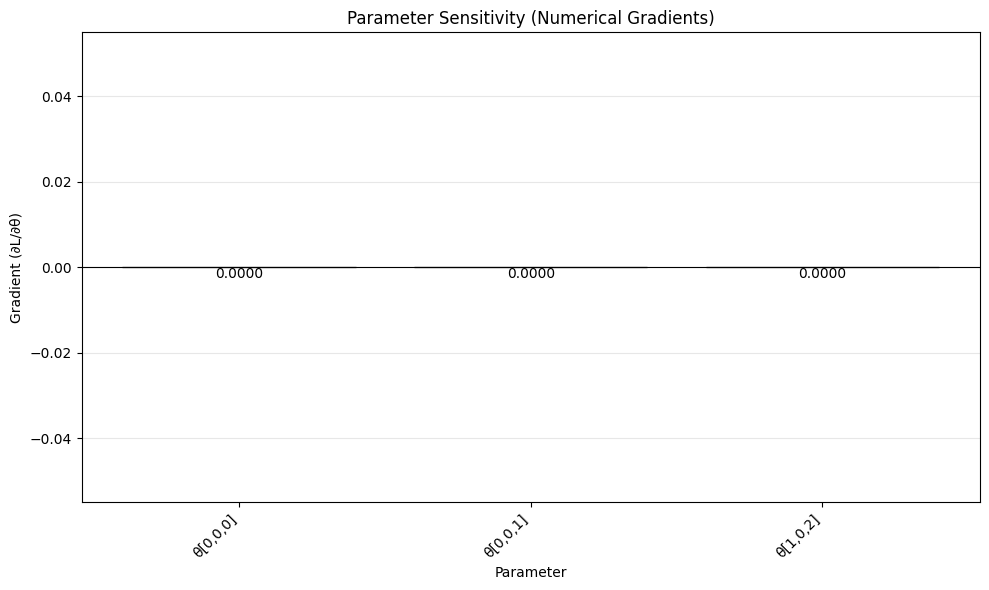

In [6]:
# Set up
set_seed(42)
n_qubits = 2
depth = 2
pairs = get_default_pairs(n_qubits)
X, y = get_toy_dataset(name="pothos_chater_small")

# Initialize parameters
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

# Compute baseline loss
baseline_result = forward_loss(
    theta=theta,
    mask=mask,
    X=X,
    y=y,
    lam=0.1,
    pairs=pairs,
    backend=None,
    n_qubits=n_qubits,
    depth=depth,
    channel_strength=0.4,
)
baseline_loss = baseline_result['total_loss']

# Compute gradients for a subset of parameters
h = 1e-5
gradients = []
param_indices = []

# Sample a few parameters to test
test_params = [
    (0, 0, 0),  # depth=0, qubit/edge=0, param=0
    (0, 0, 1),  # depth=0, qubit/edge=0, param=1
    (1, 0, 2),  # depth=1, qubit/edge=0, param=2
]

print("=" * 60)
print("Parameter Sensitivity Analysis")
print("=" * 60)
print(f"Baseline loss: {baseline_loss:.6f}\n")

for d, q, k in test_params:
    # Perturb parameter
    theta_pert = theta.copy()
    theta_pert[d, q, k] += h
    
    # Compute perturbed loss
    pert_result = forward_loss(
        theta=theta_pert,
        mask=mask,
        X=X,
        y=y,
        lam=0.1,
        pairs=pairs,
        backend=None,
        n_qubits=n_qubits,
        depth=depth,
        channel_strength=0.4,
    )
    pert_loss = pert_result['total_loss']
    
    # Compute gradient
    grad = (pert_loss - baseline_loss) / h
    gradients.append(grad)
    param_indices.append(f"θ[{d},{q},{k}]")
    
    print(f"Parameter θ[{d},{q},{k}]:")
    print(f"  Baseline loss: {baseline_loss:.6f}")
    print(f"  Perturbed loss: {pert_loss:.6f}")
    print(f"  Gradient: {grad:.6f}")

# Visualize gradients
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
bars = ax.bar(range(len(gradients)), gradients, alpha=0.7, edgecolor='black')
ax.set_xlabel('Parameter')
ax.set_ylabel('Gradient (∂L/∂θ)')
ax.set_title('Parameter Sensitivity (Numerical Gradients)')
ax.set_xticks(range(len(param_indices)))
ax.set_xticklabels(param_indices, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='black', linewidth=0.8)

# Add value labels on bars
for i, (bar, grad) in enumerate(zip(bars, gradients)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{grad:.4f}',
            ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()


In [ ]:
# Build ansatz
n_qubits = 3
depth = 3
pairs = get_default_pairs(n_qubits)

set_seed(42)
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)
mask = init_full_mask(depth, len(pairs))

ansatz = build_ansatz(
    n_qubits=n_qubits,
    depth=depth,
    theta=theta,
    mask=mask,
    pairs=pairs
)

print("=" * 60)
print("Transpilation Visualization")
print("=" * 60)

# Count gates before
twoq_before = sum(1 for inst in ansatz.data if len(inst.qubits) == 2)
oneq_before = sum(1 for inst in ansatz.data if len(inst.qubits) == 1)

print("\nBefore transpilation:")
print(f"  Circuit depth: {ansatz.depth()}")
print(f"  1-qubit gates: {oneq_before}")
print(f"  2-qubit gates: {twoq_before}")

# Transpile (return_dict=True to get dictionary format)
transpiled_result = transpile_and_count_2q(ansatz, backend=None, return_dict=True)
transpiled_circuit = transpiled_result["circuit"]
twoq_after = transpiled_result["n_2q"]
oneq_after = transpiled_result["n_1q"]
depth_after = transpiled_result["depth"]

print("\nAfter transpilation:")
print(f"  Circuit depth: {depth_after}")
print(f"  1-qubit gates: {oneq_after}")
print(f"  2-qubit gates: {twoq_after}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gate count comparison
categories = ['1-qubit', '2-qubit']
before_counts = [oneq_before, twoq_before]
after_counts = [oneq_after, twoq_after]

x = np.arange(len(categories))
width = 0.35

axes[0].bar(x - width/2, before_counts, width, label='Before', alpha=0.8, edgecolor='black')
axes[0].bar(x + width/2, after_counts, width, label='After', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Gate Type')
axes[0].set_ylabel('Count')
axes[0].set_title('Gate Count: Before vs After Transpilation')
axes[0].set_xticks(x)
axes[0].set_xticklabels(categories)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (b, a) in enumerate(zip(before_counts, after_counts)):
    axes[0].text(i - width/2, b, str(b), ha='center', va='bottom')
    axes[0].text(i + width/2, a, str(a), ha='center', va='bottom')

# Depth comparison
axes[1].bar(['Before', 'After'], [ansatz.depth(), depth_after], 
            alpha=0.8, edgecolor='black', color=['skyblue', 'lightcoral'])
axes[1].set_ylabel('Circuit Depth')
axes[1].set_title('Circuit Depth: Before vs After Transpilation')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels
axes[1].text(0, ansatz.depth(), str(ansatz.depth()), ha='center', va='bottom')
axes[1].text(1, depth_after, str(depth_after), ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Draw circuits side by side
print("\nOriginal circuit:")
try:
    display(ansatz.draw(output='mpl', style='clifford'))
except Exception:
    print("Using text output:")
    print(ansatz.draw(output='text', style='clifford'))

print("\nTranspiled circuit:")
try:
    display(transpiled_circuit.draw(output='mpl', style='clifford'))
except Exception:
    print("Using text output:")
    print(transpiled_circuit.draw(output='text', style='clifford'))


Transpilation Visualization

Before transpilation:
  Circuit depth: 24
  1-qubit gates: 18
  2-qubit gates: 18


TypeError: tuple indices must be integers or slices, not str

In [ ]:
# Extract parameters for a single Heisenberg block
n_qubits = 2
depth = 1
pairs = get_default_pairs(n_qubits)

set_seed(42)
theta = init_random_theta(n_qubits, depth, len(pairs), scale=0.1, seed=42)

# Get parameters for first block (depth=0, edge=0)
d, k = 0, 0
alpha = theta[d, k, 0]
beta = theta[d, k, 1]
gamma = theta[d, k, 2]

print("=" * 60)
print("Heisenberg Block Visualization")
print("=" * 60)
print(f"Block parameters (depth={d}, edge={k}):")
print(f"  α (alpha): {alpha:.4f}")
print(f"  β (beta): {beta:.4f}")
print(f"  γ (gamma): {gamma:.4f}")

# Build a circuit with just this block
from qiskit import QuantumCircuit
qc = QuantumCircuit(2)
qc = heisenberg_entangler_block(
    qc, qubit0=0, qubit1=1,
    alpha=alpha, beta=beta, gamma=gamma
)

print(f"\nHeisenberg block circuit:")
print(qc)

# Visualize
try:
    display(qc.draw(output='mpl', style='clifford'))
except Exception:
    print("Using text output:")
    print(qc.draw(output='text', style='clifford'))

# Plot parameter values
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
params = ['α', 'β', 'γ']
values = [alpha, beta, gamma]
colors = ['red', 'green', 'blue']

bars = ax.bar(params, values, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Parameter Value')
ax.set_title('Heisenberg Block Parameters')
ax.grid(True, alpha=0.3, axis='y')
ax.axhline(0, color='black', linewidth=0.8)

# Add value labels
for bar, val in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.4f}',
            ha='center', va='bottom' if height > 0 else 'top')

plt.tight_layout()
plt.show()

print("\n" + "=" * 60)
print("✓ Heisenberg block visualization complete!")
